### Plot long-term forgetting fit parameters across different benchmark datasets

In [2]:
import os

In [1]:
import os
os.chdir('/Users/haozheshan/Dropbox/codes/gp_continual_learning/')
import numpy as np
import matplotlib.pyplot as plt
import theory, cluster_utils, torch, data, utils, tqdm, scipy.optimize

%load_ext autoreload
%autoreload 2   

# folder_names = ['gp_30x500_cifar_permuted_diff_depth',
#                  'gp_30x500_fashion_permuted_diff_depth',
#                  'gp_30x500_mnist_permuted_diff_depth',
#                  'gp_30x500_emnist_permuted_diff_depth',
#                  'gp_5x500_cifar_split_diff_depth',
#                  'gp_5x500_fashion_split_diff_depth',
#                  'gp_5x500_mnist_split_diff_depth']

folder_names = ['gp_30x500_cifar_permuted_diff_depth',
                 'gp_30x500_fashion_permuted_diff_depth',
                 'gp_30x500_mnist_permuted_diff_depth',
                 'gp_30x500_emnist_permuted_diff_depth']


# Fit curves from different datasets
m_taus = []
a_taus = []
m_asymptotes = []
a_asymptotes = []
L1s = []
M1s = []
A1s = []

L12s = []
L21s = []

trP1P2s = []
V_Sigma_Vs = []
V1_Sigma_V2s = []

for folder_name in folder_names:
    organizer = cluster_utils.ClusterResultOrganizer('cluster_results/', batch_name=folder_name, sort_by_key='depth')

    all_train_loss = organizer.organize_results('train loss')
    all_train_mag = organizer.organize_results('train magnitude')

    for key in ['1', '3', '5', '7', '9']:
        L1 = all_train_loss[key].mean(0)[0]
        M1 = all_train_mag[key].mean(0)[0]
        A1 = (L1 - M1 - 1) * -0.5

        L1s.append(L1)
        M1s.append(M1)
        A1s.append(A1)

        L12s.append(L1[1])
        L21s.append(all_train_loss[key].mean(0)[1, 0])

        m_asympt, m_tau, _ = utils.exponential_fit(np.arange(len(M1)), M1)
        a_asympt, a_tau, _ = utils.exponential_fit(np.arange(len(A1)), A1)

        m_taus.append(m_tau)
        a_taus.append(a_tau)
        m_asymptotes.append(m_asympt)
        a_asymptotes.append(a_asympt)
        V_Sigma_Vs.append(organizer.organize_results('Vt_Sigma1_Vt')[key].mean(0))
        V1_Sigma_V2s.append(organizer.organize_results('V1_Sigma1_Vt')[key].mean(0))

        trP1P2s.append(organizer.organize_results('tr(P1P2)/P')[key].mean(0))

m_taus = np.array(m_taus)
a_taus = np.array(a_taus)
m_asymptotes = np.array(m_asymptotes)
a_asymptotes = np.array(a_asymptotes)
trP1P2s = np.array(trP1P2s)

a_rates = - np.exp(1 / a_taus)
a_gains = a_asymptotes * (1 - a_rates)

RuntimeError: Loading cluster_results//gp_30x500_cifar_permuted_diff_depth/gp_30x500_cifar_permuted_diff_depth_1373.results failed.

=================== Cluster organizer ===================
1999 data objects loaded from folder "gp_30x500_mnist_permuted_diff_depth".
For key <<depth>>, the values are [9, 3, 5, 1, 7]
=================== Cluster organizer ===================
Available data keys are dict_keys(['args', 'train loss', 'test loss', 'train acc', 'test acc', 'train magnitude', 'Vt_Sigma1_Vt', 'V1_Sigma1_Vt', 'V1_V1', 'tr(P1P2)/P'])
For depth=1, l_tau=8.81, m_rate=3.67, a_rate=7.15 l_asym=0.83, m_asym=0.75, a_asym=0.47
For depth=3, l_tau=30.29, m_rate=11.32, a_rate=16.50 l_asym=0.59, m_asym=0.58, a_asym=0.55
For depth=5, l_tau=65.33, m_rate=19.43, a_rate=26.36 l_asym=0.64, m_asym=0.49, a_asym=0.53
For depth=7, l_tau=129.08, m_rate=27.15, a_rate=35.84 l_asym=0.89, m_asym=0.39, a_asym=0.48
For depth=9, l_tau=598.80, m_rate=31.85, a_rate=42.68 l_asym=3.35, m_asym=0.29, a_asym=0.41


Text(0.5, 0.98, 'gp_30x500_cifar_permuted_diff_depth')

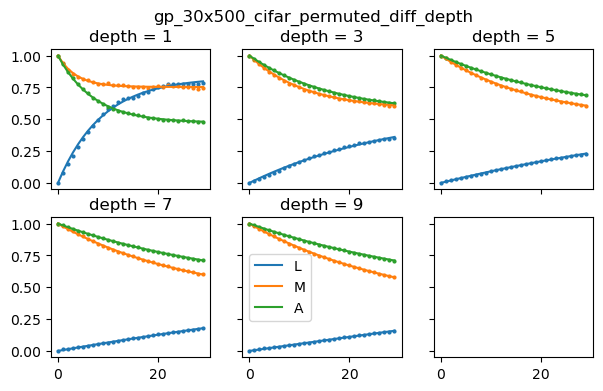

In [89]:
organizer = cluster_utils.ClusterResultOrganizer('cluster_results/', batch_name='gp_30x500_mnist_permuted_diff_depth', sort_by_key='depth')
all_train_loss = organizer.organize_results('train loss')
all_train_mag = organizer.organize_results('train magnitude')

fit, axes = plt.subplots(ncols=3, nrows=2, figsize=(7, 4), sharex=True, sharey=True)
axes = axes.ravel()


a_rates = []
a_gains = []
two_task_forgetting = []
for i, key in enumerate(['1', '3', '5', '7', '9']):
    plt.sca(axes[i])
    L1 = all_train_loss[key].mean(0)[0]
    M1 = all_train_mag[key].mean(0)[0]
    A1 = (L1 - M1 - 1) * -0.5
    rl, gl, _ = utils.plot_and_exp_fit(L1, label='L')
    rm ,gm, _ = utils.plot_and_exp_fit(M1, label='M')
    ra, ga, _ = utils.plot_and_exp_fit(A1, label='A')
    a_rates.append(ra)
    a_gains.append(ga)
    two_task_forgetting.append(L1[1])
    plt.title(f'depth = {key}')
    print(f'For depth={key}, l_tau={-1/np.log(rl):.2f}, m_rate={-1/np.log(rm):.2f}, a_rate={-1/np.log(ra):.2f}'
          f' l_asym={gl/(1-rl):.2f}, m_asym={gm/(1-rm):.2f}, a_asym={ga/(1-ra):.2f}')
plt.legend()
plt.suptitle('gp_30x500_cifar_permuted_diff_depth')

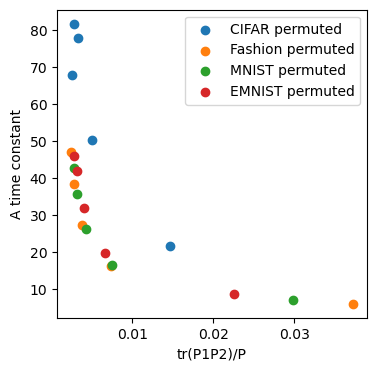

In [94]:

def smart_plot(x, y, last_perm_ind=4, total_ind=7, nums_per_dataset=5, labels=None):
    if labels is None:
        labels = [None for i in range(len(x))]
    for i in range(last_perm_ind):
        plt.scatter(x[i*5:i*5+nums_per_dataset], y[i*5:i*5+nums_per_dataset], label=labels[i])
    if int(len(x) / 5) > last_perm_ind:
        for i in range(last_perm_ind, total_ind):
            plt.scatter(x[i*5:i*5+nums_per_dataset], y[i*5:i*5+nums_per_dataset], marker='x', label=labels[i])

labels = ['CIFAR permuted', 'Fashion permuted', 'MNIST permuted', 'EMNIST permuted']

plt.figure(figsize=(4, 4))
# smart_plot(trP1P2s[:20], a_taus[:20], labels=labels)
# smart_plot(trP1P2s[:20], np.exp(-1/a_taus[:20]), labels=labels)
smart_plot(trP1P2s, a_taus, labels=labels)
plt.xlabel('tr(P1P2)/P')
plt.ylabel('A time constant')
plt.legend()


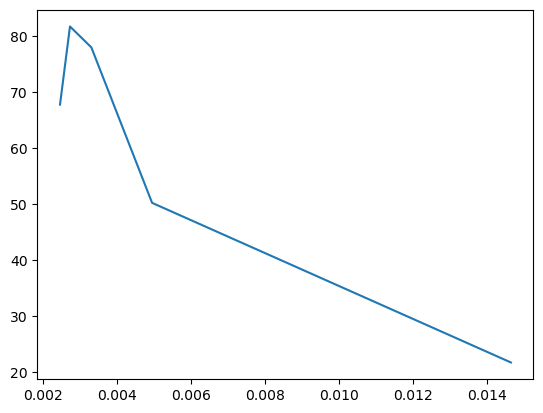

In [95]:
plt.figure()
plt.plot(trP1P2s[:5], a_taus[:5])

plt.figure()
plt.plot(trP1P2s[:5], a_taus[:5])

IndexError: list index out of range

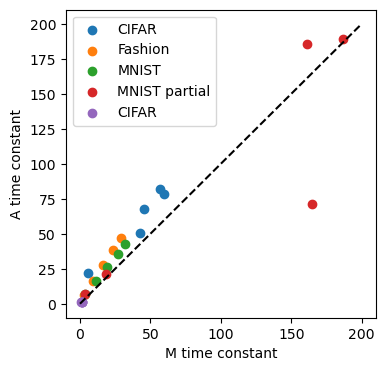

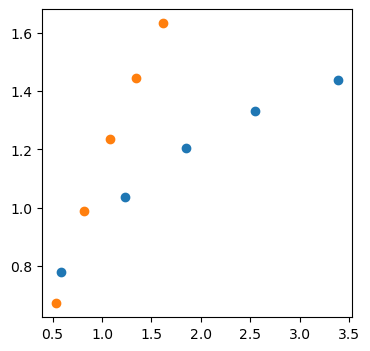

In [147]:

plt.figure(figsize=(4, 4))
for i in range(5):
    plt.scatter(m_taus[i*5:(i+1)*5], a_taus[i*5:(i+1)*5], label=labels[i])
plt.plot([0, 200], [0, 200], 'k--')
plt.xlabel('M time constant')
plt.ylabel('A time constant')
plt.legend()


plt.figure(figsize=(4, 4))
for i in range(5, 8):
    plt.scatter(m_taus[i*5:(i+1)*5], a_taus[i*5:(i+1)*5], label=labels[i])
plt.plot([0, 2], [0, 2], 'k--')
plt.xlabel('M time constant')
plt.ylabel('A time constant')
plt.legend()
# plt.xscale('log')
# plt.yscale('log')

# plt.figure()
# smart_plot(- 1 / np.log(m_rates), - 1 / np.log(a_rates))
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('$r_M$')
# plt.ylabel('$r_A$')

## Code for on-demand computation of OPs in benchmark datasets

In [75]:
all_class_1_train_x, all_class_2_train_x, all_class_1_test_x, all_class_2_test_x = data._load_and_two_classify_dataset('cifar', None)
P = 500

In [76]:
def get_params(input_arr1, input_arr2, y, depth):
    # k1 = theory.k_ntk(input_arr1, input_arr1, depth)
    # k12 = theory.k_ntk(input_arr1, input_arr2, depth)
    k1 = theory.arccos_kernel_deep(input_arr1, input_arr1, depth)
    k12_gp = theory.arccos_kernel_deep(input_arr1, input_arr2, depth)
    k12_ntk = theory.k_ntk(input_arr1, input_arr2, depth) * 1e5
    k2 = theory.k_ntk(input_arr2, input_arr2, depth) * 1e5

    inv_k1 = torch.inverse(k1)
    inv_k2 = torch.inverse(k2)

    # p1S2p1 = float(torch.trace(inv_k1 @ k12 @ k12.T) / torch.trace(k1))
    # v1S2v1 = float(torch.trace(y.T @ inv_k1 @ k12 @ k12.T @ inv_k1 @ y) / input_arr1.shape[0])
    p1p2 = float(torch.trace(inv_k1 @ k12_gp @ inv_k2 @ k12_gp.T) / input_arr1.shape[0])
    # p1p2p1p2 = float(torch.trace(inv_k1 @ k12 @ inv_k2 @ k12.T @ inv_k1 @ k12 @ inv_k2 @ k12.T) / input_arr1.shape[0])
    v1_minus_v2 = float(2 - 2 * y.T @ inv_k1 @ k12_gp @ inv_k2 @ y / (y.T @ inv_k1 @ y))
    # v1p2s1v1 = float(y.T @ inv_k1 @ k12 @ inv_k2 @ k12.T @ y / k1.shape[0])

    two_task_forgetting = torch.norm(k12_ntk @ inv_k2 @ (y - k12_gp.T @ inv_k1 @ y))**2 / len(y)

    # return v1S2v1, v1_minus_v2, p1p2, p1p2p1p2, v1p2s1v1, two_task_forgetting
    return 0, v1_minus_v2, p1p2, 0, 0, two_task_forgetting

nseeds = 50
depths = np.arange(1, 10)
v1s2v1_arr = np.zeros((len(depths), nseeds))
v1minusv2_arr = np.zeros((len(depths), nseeds))
p1p2_arr = np.zeros((len(depths), nseeds))
p1p2p1p2_arr = np.zeros((len(depths), nseeds))
v1p2s1v1_arr = np.zeros((len(depths), nseeds))
two_task_forgetting = np.zeros((len(depths), nseeds))

for i in range(len(depths)):
    for j in range(nseeds):
        tr_x, _, tr_y, _ = data._generate_permuted_dataset_from_two_classes(all_class_1_train_x, all_class_2_train_x, all_class_1_test_x, all_class_2_test_x,
                                                                                  permutation=1.0, num_tasks=2, train_p=P, test_p=1)

        v1s2v1_arr[i, j], v1minusv2_arr[i, j], p1p2_arr[i, j], p1p2p1p2_arr[i, j],\
        v1p2s1v1_arr[i, j], two_task_forgetting[i, j] = get_params(tr_x[0], tr_x[1], tr_y[0], depth=depths[i])
        


/Users/haozheshan/Dropbox/codes/gp_continual_learning/theory.py:247: UserWarning: arccosine kernel computation is assuming that all inputs have the same norm.
  warnings.warn('arccosine kernel computation is assuming that all inputs have the same norm.')


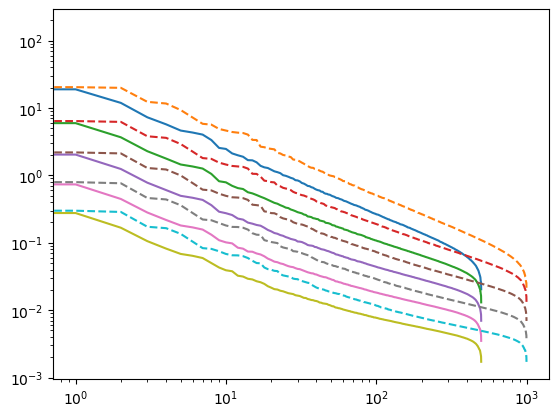

In [86]:

plt.figure()

combined_tr = torch.concatenate([tr_x[0], tr_x[1]], axis=0)

for i in range(5):
    k = theory.arccos_kernel_deep(tr_x[0], tr_x[0], depth=depths[i])
    k_prime = theory.arccos_kernel_deep(combined_tr, combined_tr, depth=depths[i])
    _, s, v = torch.svd(k)
    plt.plot(s)
    _, s, v = torch.svd(k_prime)
    plt.plot(s, ls='--')
plt.yscale('log')
plt.xscale('log')

AttributeError: 'list' object has no attribute 'mean'

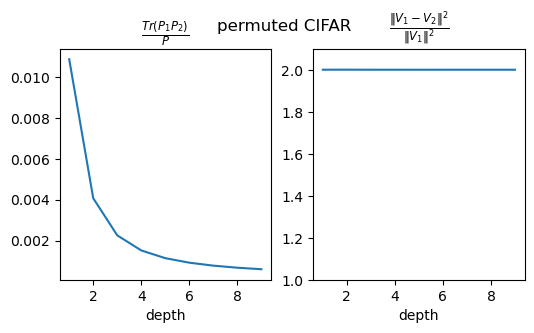

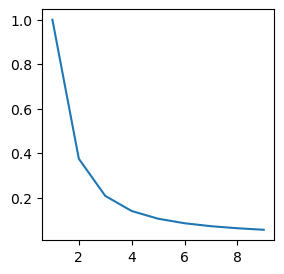

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
plt.sca(axes[0])
plt.plot(depths, p1p2_arr.mean(1))
# plt.plot(depths, v1s2v1_arr.mean(1), marker='o')
plt.xlabel('depth')
plt.title('$\\frac{Tr(P_1 P_2)}{P}$')
# plt.ylim(0, 1.0)
plt.sca(axes[1])
plt.plot(depths, v1minusv2_arr.mean(1))
plt.xlabel('depth')
plt.title('$\\frac{\Vert V_1 - V_2 \Vert^2}{\Vert V_1 \Vert^2}$')
plt.ylim(1, 2.1)
plt.suptitle('permuted CIFAR')
# plt.tight_layout()

prod_of_ops = p1p2_arr.mean(1) * 2
plt.figure(figsize=(3, 3))
plt.plot(depths, prod_of_ops / prod_of_ops[0], label='product of OPs (normalized)')
plt.plot(depths, two_task_forgetting.mean(1) / two_task_forgetting.mean(1)[0], label='actual (normalized)')
plt.legend()
plt.xlabel('depth')

plt.figure(figsize=(3, 3))
plt.plot(depths, prod_of_ops, label='product of OPs')
plt.plot(depths, two_task_forgetting.mean(1), label='two-task forgetting')
plt.legend()
plt.xlabel('depth')

ValueError: x and y must have same first dimension, but have shapes (9,) and (20,)

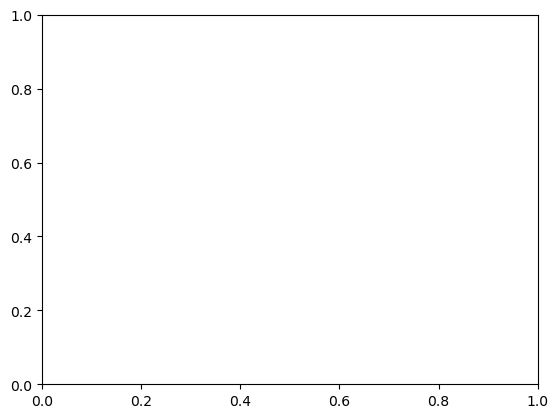

In [92]:
plt.figure()
plt.plot(depths, a_taus)

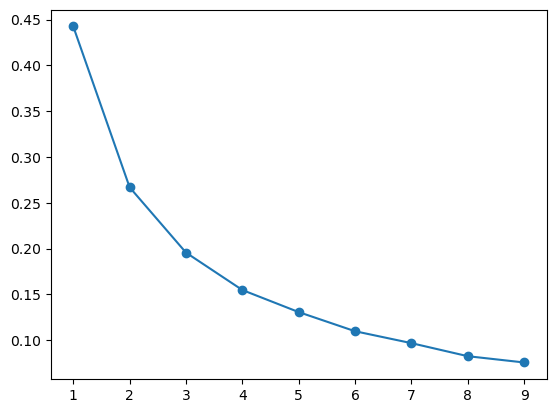

In [16]:
plt.figure()
plt.plot(depths, p1p2_arr.mean(1) * v1minusv2_arr.mean(1), marker='o')

plt.figure()
plt.plot(depths, p1p2p1p2_arr.mean(1), marker='o')


In [26]:
a_taus

array([21.70424561, 50.22985565, 78.01906644, 81.75256326, 67.78951141,
        6.10533181, 16.19007332, 27.39231352, 38.47889502, 46.97645409,
        7.14556955, 16.49965614, 26.35698362, 35.83859228, 42.67626353,
        8.79828069, 19.90569513, 31.92318878, 42.06833887, 46.03405296,
        0.90459808,  1.03389754,  1.14455198,  1.2488257 ,  1.35019251,
        0.77940541,  1.03796121,  1.20375386,  1.33267288,  1.43948994,
        0.67220386,  0.9875825 ,  1.23460915,  1.44636047,  1.63292821])

In [27]:
toy_trP1P2[key].mean()

0.04750530058290654

In [1]:
plt.figure()
organizer = cluster_utils.ClusterResultOrganizer('cluster_results/', batch_name='gp_toy_30x50_tsim0_xsim0_diff_depth')
toy_m_tau = organizer.organize_results('M tau')
toy_a_tau = organizer.organize_results('A tau')
toy_trP1P2 = organizer.organize_results('tr(P1P2)/P')

for key in toy_m_tau:
    plt.scatter(toy_trP1P2[key].mean(), a_taus[:20], color='k', marker='x')

organizer = cluster_utils.ClusterResultOrganizer('cluster_results/', batch_name='gp_toy_30x50_tsim0_1L_diff_xsim')
toy_m_tau = organizer.organize_results('M tau')
toy_a_tau = organizer.organize_results('A tau')
toy_trP1P2 = organizer.organize_results('tr(P1P2)/P')

for key in toy_m_tau:
    if key != '1.0':
        plt.scatter(toy_trP1P2[key].mean(), a_taus[:20], color='k', marker='x')
smart_plot(trP1P2s[:20], a_taus[:20], labels=labels)
plt.xlabel('Tr(P1P2) / P')
plt.ylabel('A rate')
plt.legend()

NameError: name 'plt' is not defined